# Estimating the correlation length 

* A central parameter for the `DIVAnd` analysis is the correlation length.
* It determines whether two points separated by a given distance are correlated or not.
* `DIVAnd` includes several tools to estimate the correlation length.
* We will start with a 2D case and consider the 3D case.

In [1]:
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random

# Data reading
Download the data file `Salinity.bigfile` (if it is not already present). It will be placed in the same directory as this notebook. This file is a space-separated file containing data based on the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html).

In [2]:
fname = "../data/Salinity.bigfile"

if !isfile(fname)
    download("https://dox.ulg.ac.be/index.php/s/k0f7FxA7l5FIgu9/download", fname)
else
    @info("Data file already downloaded")
end

┌ Info: Data file already downloaded
└ @ Main In[2]:6


Load the data

In [3]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadbigfile(fname);

┌ Info: Loading data from 'big file' ../data/Salinity.bigfile
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/load_obs.jl:10


`mincount` is the minimum number of observations per distance bin and the call to [`seed!`](https://docs.julialang.org/en/v1/stdlib/Random/#Random.seed!) (seed for the random number generator) ensures a reproducible sequence of random numbers.

In [4]:
mincount = 100
Random.seed!(12345);

## 2D case

* First lets consider only the data on a 2D surface (longitude and latitude)
* We use the function `DIVAnd.fit_isotropic`


In [5]:
?fit_isotropic

search: fit_isotropic



```
var0,len,distx,covar,fitcovar = fit_isotropic(x,v,distbin,mincount;
                           alpha = DIVAnd.alpha_default(length(x)),
                           minlen = 0.,
                           maxlen = 10.,
                           tolrel = 1e-4,
                           maxpoints = 10000,
                           nmean = 100,
                           distfun = (xi,xj) -> sqrt(sum(abs2,xi-xj))),
                           progress = (iter,var,len,fitness) -> nothing
                       )
```

Determines the optimal correlation length `len` and variance (for a separation distance approaching zero) `var0` of a cloud of data points with value `v` and coordiantes `x` (tuple of vectors with the coordinates).

The function can find the solution corresponding to a local minimum which is not necessarily the global minimum.

See also `empiriccovar` for future information about the output parameters.

Optional input parameters:

  * `alpha`: if one correlation length is forced to zero during the anaylsis the values of alpha sould be set using the effective dimension. For example, if a 2D-analysis is simulated by forcing the vertical correlation length to zero, then alpha should be set to `[1,2,1]`, otherwise alpha will be `[1,3,3,1]` (for any proper 3D analysis).
  * `len`: initial value for the correlation length.
  * `minlen`, `maxlen`: minimum and maximum values for the correlation length.
  * `tolrel`: relative tolerance for the optimizer.
  * `maxpoints`: maximum number of data points considered.
  * `nmean`: the number of times an empirical covariance is estimated.  The average covariance is used for the fitting.
  * `distfun`: function to compute the distance between point `xi` (vector) and  `xj`. Per default `distfun` is the Euclidian distance: `(xi,xj) -> sqrt(sum(abs2,xi-xj)))`.
  * `progress`: call-back function to show the progress of the optimization with the input parameters `iter`, `var`, `len` and `fitness` (all scalars).

The length-scale parameters and the variance have the corresponding units from the `x` and `v`. It is therefore often necessary to provide reasonable values for these default parameters.

The algorithm used to estimate the correlation-length and variance is based on randomly choosen points. Therefore the result can be different if the function is invoked repeately. If `nmean` is increased, then these statistical fluctuations should decrease (for a not too large value of `mincount`, i.e. about 100 for most cases).

If the lower bound `minlen` is too small, then you might get the following error:

```
AmosException with id 4: input argument magnitude too large, complete loss of accuracy by argument reduction.
```

In these case, increase `minlen`.


## Example 1: salinity in the Black Sea
The profiles were already vertically interpolated on standard depth levels.     
We select the values near surface (above 10 m), for the month of January.

In [6]:
# surface values for the month January
sel = (obsdepth .< 10) .& Dates.month.(obstime) .== 1;
x = (obslon[sel],obslat[sel]);
v = obsval[sel] .- mean(obsval[sel]);
distbin = 0:0.5:4

var0,len,distx,covar,fitcovar = fit_isotropic(x,v,distbin,mincount)

(26.92085356212525, 0.3940490099009901, [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75], [26.92085356212525, 11.174141203730096, 3.643408819602061, 1.1421733518528638, 0.19540711629254562, -0.6831435476011457, -0.9082349722577798, -1.0788901288770454], [20.611757385540354, 8.144724853772836, 2.7928044813801622, 0.9043645593016553, 0.2837956829917441, 0.08730048554018613, 0.026487573394920423, 0.007955679913501282], [5.606477034086467, 3.30815795818126, 1.649262199070091, 0.8648047523008112, 0.29205077706348015, 0.2980138798263842, 0.3675554536837001, 0.3519865351790744])

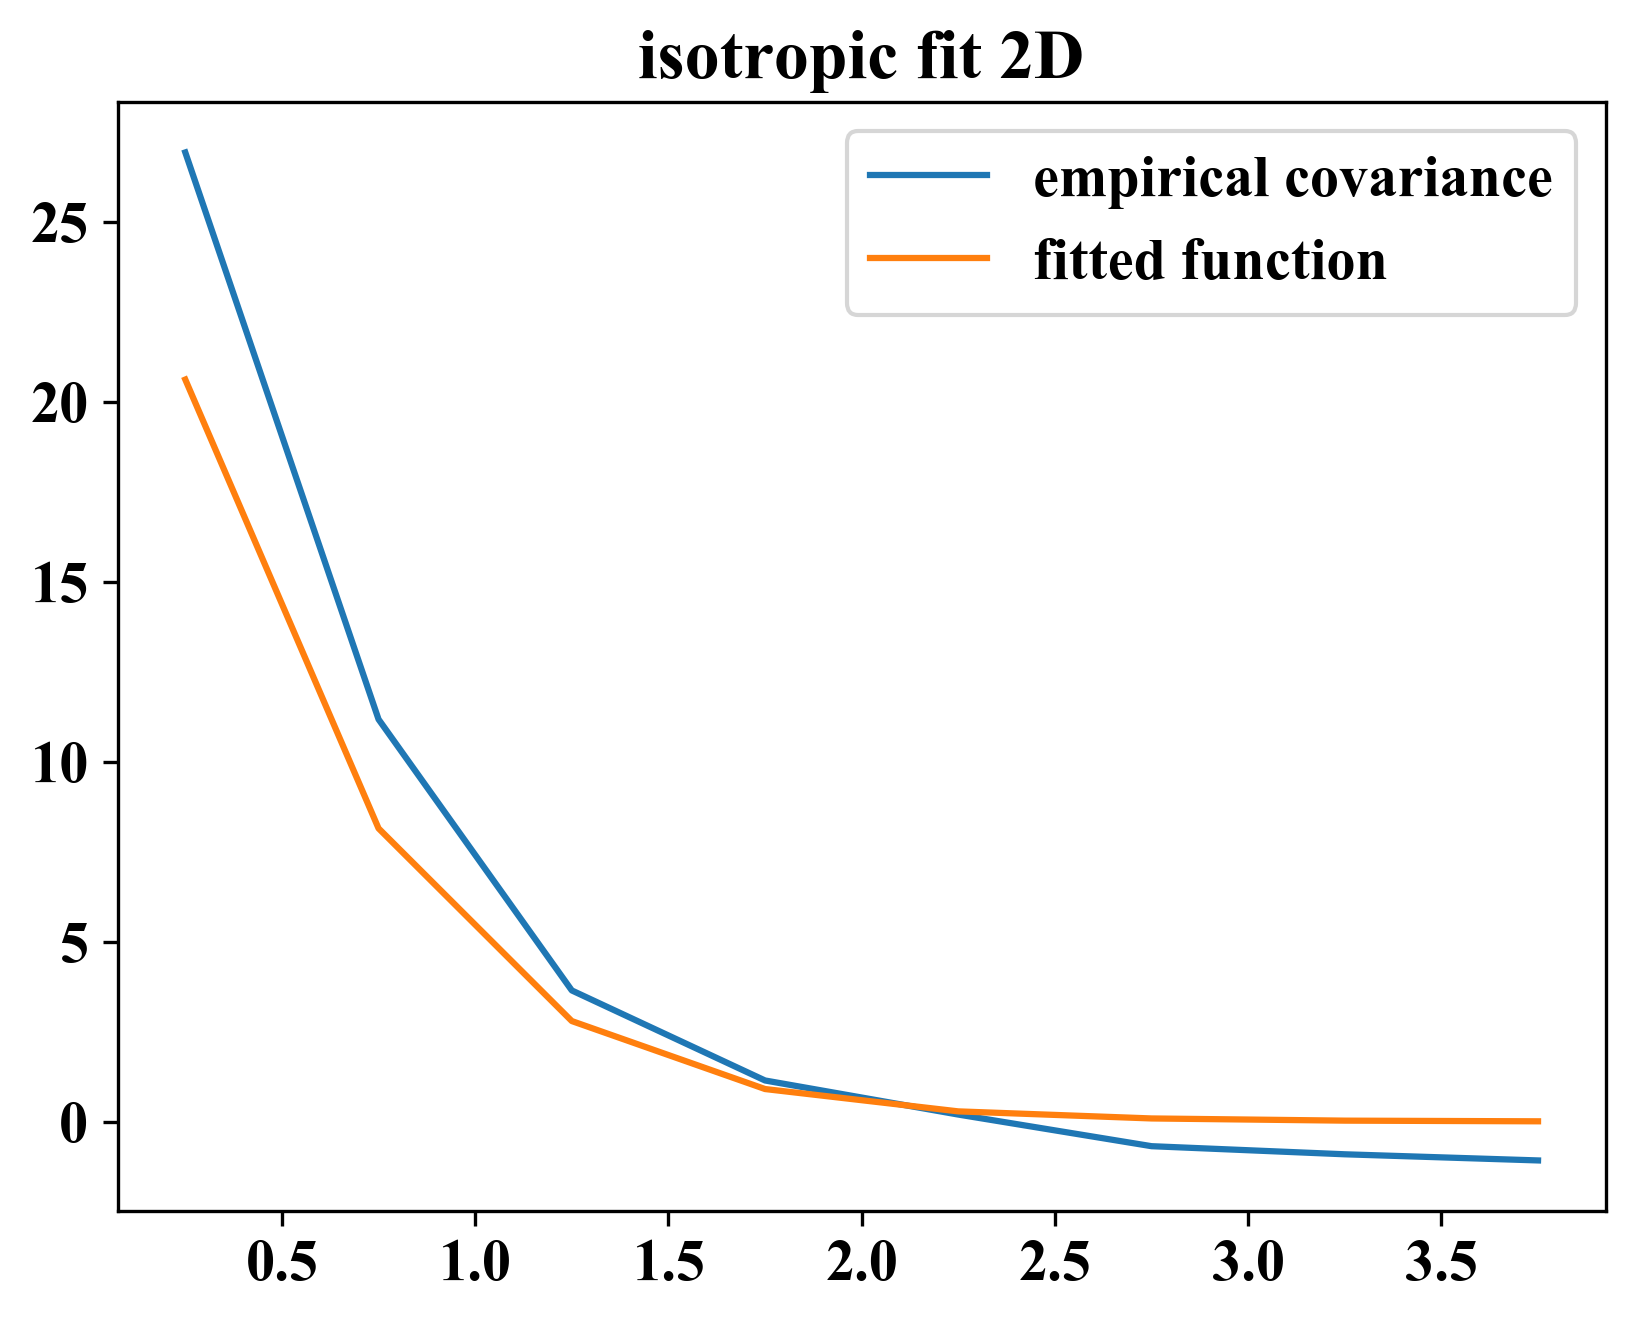

In [7]:
figure()
plot(distx,covar, label = "empirical covariance")
plot(distx,fitcovar, label = "fitted function")
legend()
title("isotropic fit 2D");

The data from the file `Salinity.bigfile` is already interpolated on standard depth levels, which makes it not ideal to explore the vertical correlation.
The file `WOD-Salinity-Provencal.nc` contains salinity measurement obtained from the World Ocean Database for the Provençal Basin (Mediterranean Sea).

The resulting correlation length can fluctuate a bit because the correlation is based on a collection of random pairs. Increasing the parameter `nmean` can make the estimation of the correlation more robust.

* Load the data file if it is not already present.
* Note we do not use the file `Salinity.bigfile` because it correspond to data already vertically interpolated which is not optimal for estimating the vertical correlation length

## Example 2: salinity in the Provençal Basin
In this case, the profiles were not interpolated vertically.

In [8]:
varname = "Salinity"
filename = "../data/WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://dox.ulg.ac.be/index.php/s/PztJfSEnc8Cr3XN/download",filename)
else
    @info("Data file $filename already downloaded")
end

┌ Info: Data file ../data/WOD-Salinity-Provencal.nc already downloaded
└ @ Main In[8]:7


Load the data and print basic information about it that can be used for quality check.

In [9]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity")
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (3.0418334007263184, 11.8100004196167)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (-0.0, 2762.0)
              minimum and maximum of obs. dimension 4: (1892-09-25T00:00:00, 2017-10-02T06:14:02.761)
                          minimum and maximum of data: (0.25, 40.0)


For this example we select only the first month (January)

In [10]:
sel = (Dates.month.(obstime) .== 1)
x = (obslon[sel],obslat[sel],obsdepth[sel]);
v = obsval[sel]
z = [0.,10,100,200,300,400,500,700,1000,1500];

### Horizontal correlation length
Estimate the horizontal correlation length for different depth levels    
(can take a few minutes).

In [11]:
Random.seed!(1234);
@time lenxy,infoxy = fithorzlen(x,v,z)

┌ Warning: Be patient big data set: 18551
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:675
┌ Info: Data points at z=0.0: 18551, horz. correlation length: 0.29007691140344244
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:1061
┌ Warning: Be patient big data set: 21948
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:675
┌ Info: Data points at z=10.0: 21948, horz. correlation length: 0.24386004187260396
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:1061
┌ Warning: Be patient big data set: 30934
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:675
┌ Info: Data points at z=100.0: 30934, horz. correlation length: 0.14412036850353693
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:1061
┌ Warning: Be patient big data set: 26778
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:675
┌ Info: Data points at z=200.0: 26778, horz. correlation length: 0.10668776687076267
└ 

 47.357349 seconds (260.43 M allocations: 22.853 GiB, 11.11% gc time)


([0.30006221782002357, 0.33310849774192747, 0.39280855786269975, 0.46637801445114274, 0.5363849307216672, 0.5856591434473559, 0.6042496295466648, 0.5946304350984323, 0.5711478891525068, 0.55278751987008], Dict{Symbol,Array{T,1} where T}(:fitinfos => Dict{Symbol,Any}[Dict(:sn => 0.2477781451541463,:rqual => 0.8293542365206041,:fitcovar => [NaN, 0.014432764655008846, 0.014049163379762959, 0.013555759343823632, 0.012996681941965486, 0.012399654966339775, 0.01178357544230248, 0.0111618236944476, 0.010544043429662302, 0.00993722039667272  …  3.278759773212963e-14, 2.997471881069907e-14, 2.7403028998399757e-14, 2.5051859567102914e-14, 2.2902311904903363e-14, 2.0937106019655076e-14, 1.9140441999209275e-14, 1.7497873321084443e-14, 1.599619099884536e-14, 1.4623317638950822e-14],:meandist => 2.1173497182733025,:covar => [0.019349807911689564, 0.016211168728752424, 0.01296959594043799, 0.011390524483554883, 0.010812732863239586, 0.010431430248616647, 0.010447474583517547, 0.011094797114642025, 0.

Make a plot of the horizontal correlation length with respect to the depth.

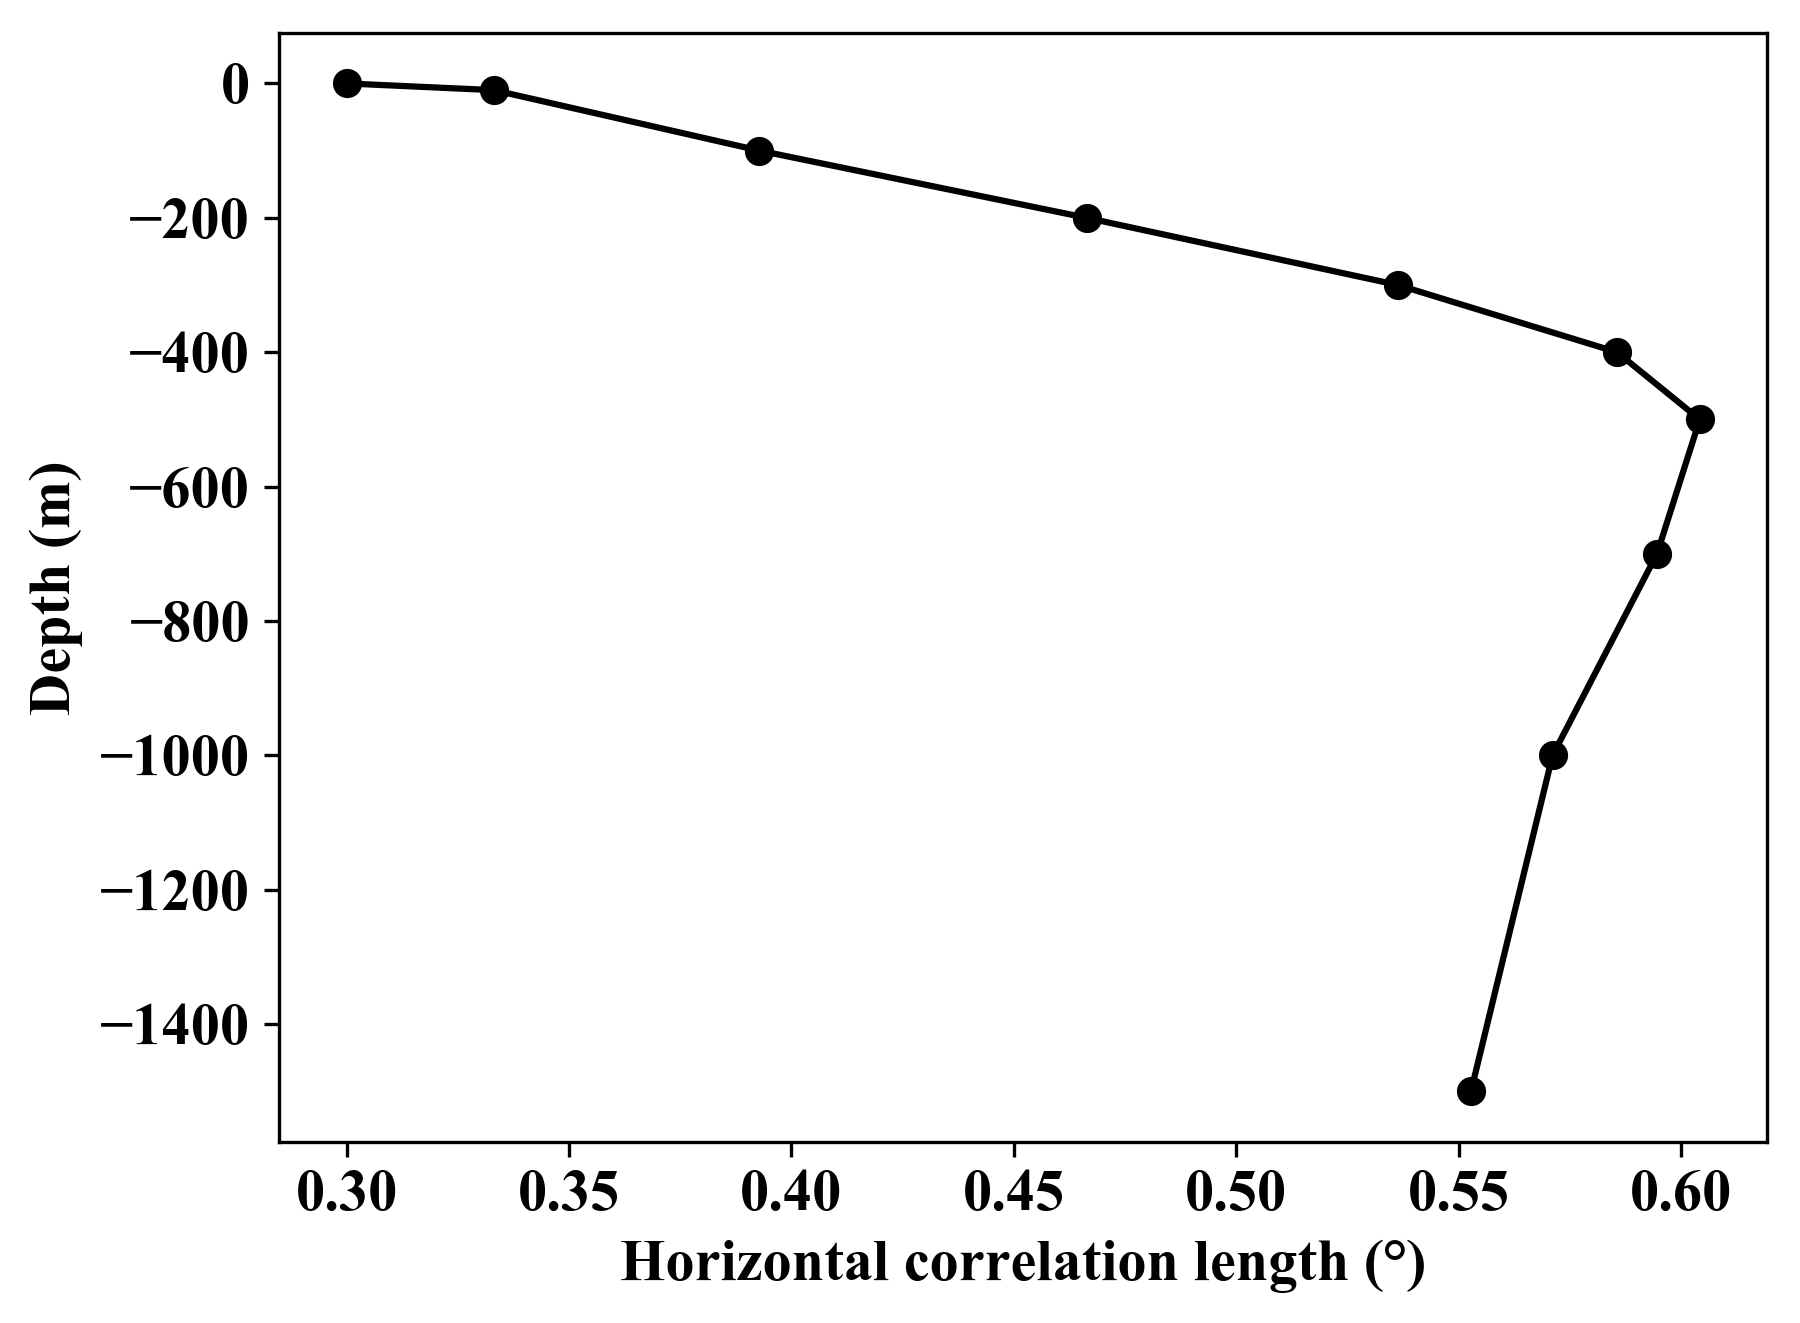

In [12]:
plot(lenxy,-z, "ko-")
xlabel("Horizontal correlation length (°)")
ylabel("Depth (m)");

### Vertical correlation length 
The vertical correlation length is also estimated for different depth levels

In [13]:
Random.seed!(1234);
@time lenz,infoz = fitvertlen(x,v,z);

┌ Info: Vert. correlation length at z=0.0: 46.55059200000001
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:1151
┌ Info: Vert. correlation length at z=10.0: 46.54409600000001
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:1151
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 178.22644592285155, )
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:894
┌ Info: Vert. correlation length at z=100.0: 178.22644592285155
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:1151
┌ Info: Vert. correlation length at z=200.0: 90.87321600000001
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:1151
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 181.6, )
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:894
┌ Info: Vert. correlation length at z=300.0: 181.6
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/pXHkM/src/fit.jl:1151
┌ Info: Vert. correlation length at z=400.0: 162.2281931074

  7.781365 seconds (36.35 M allocations: 3.148 GiB, 9.34% gc time)


Make a plot

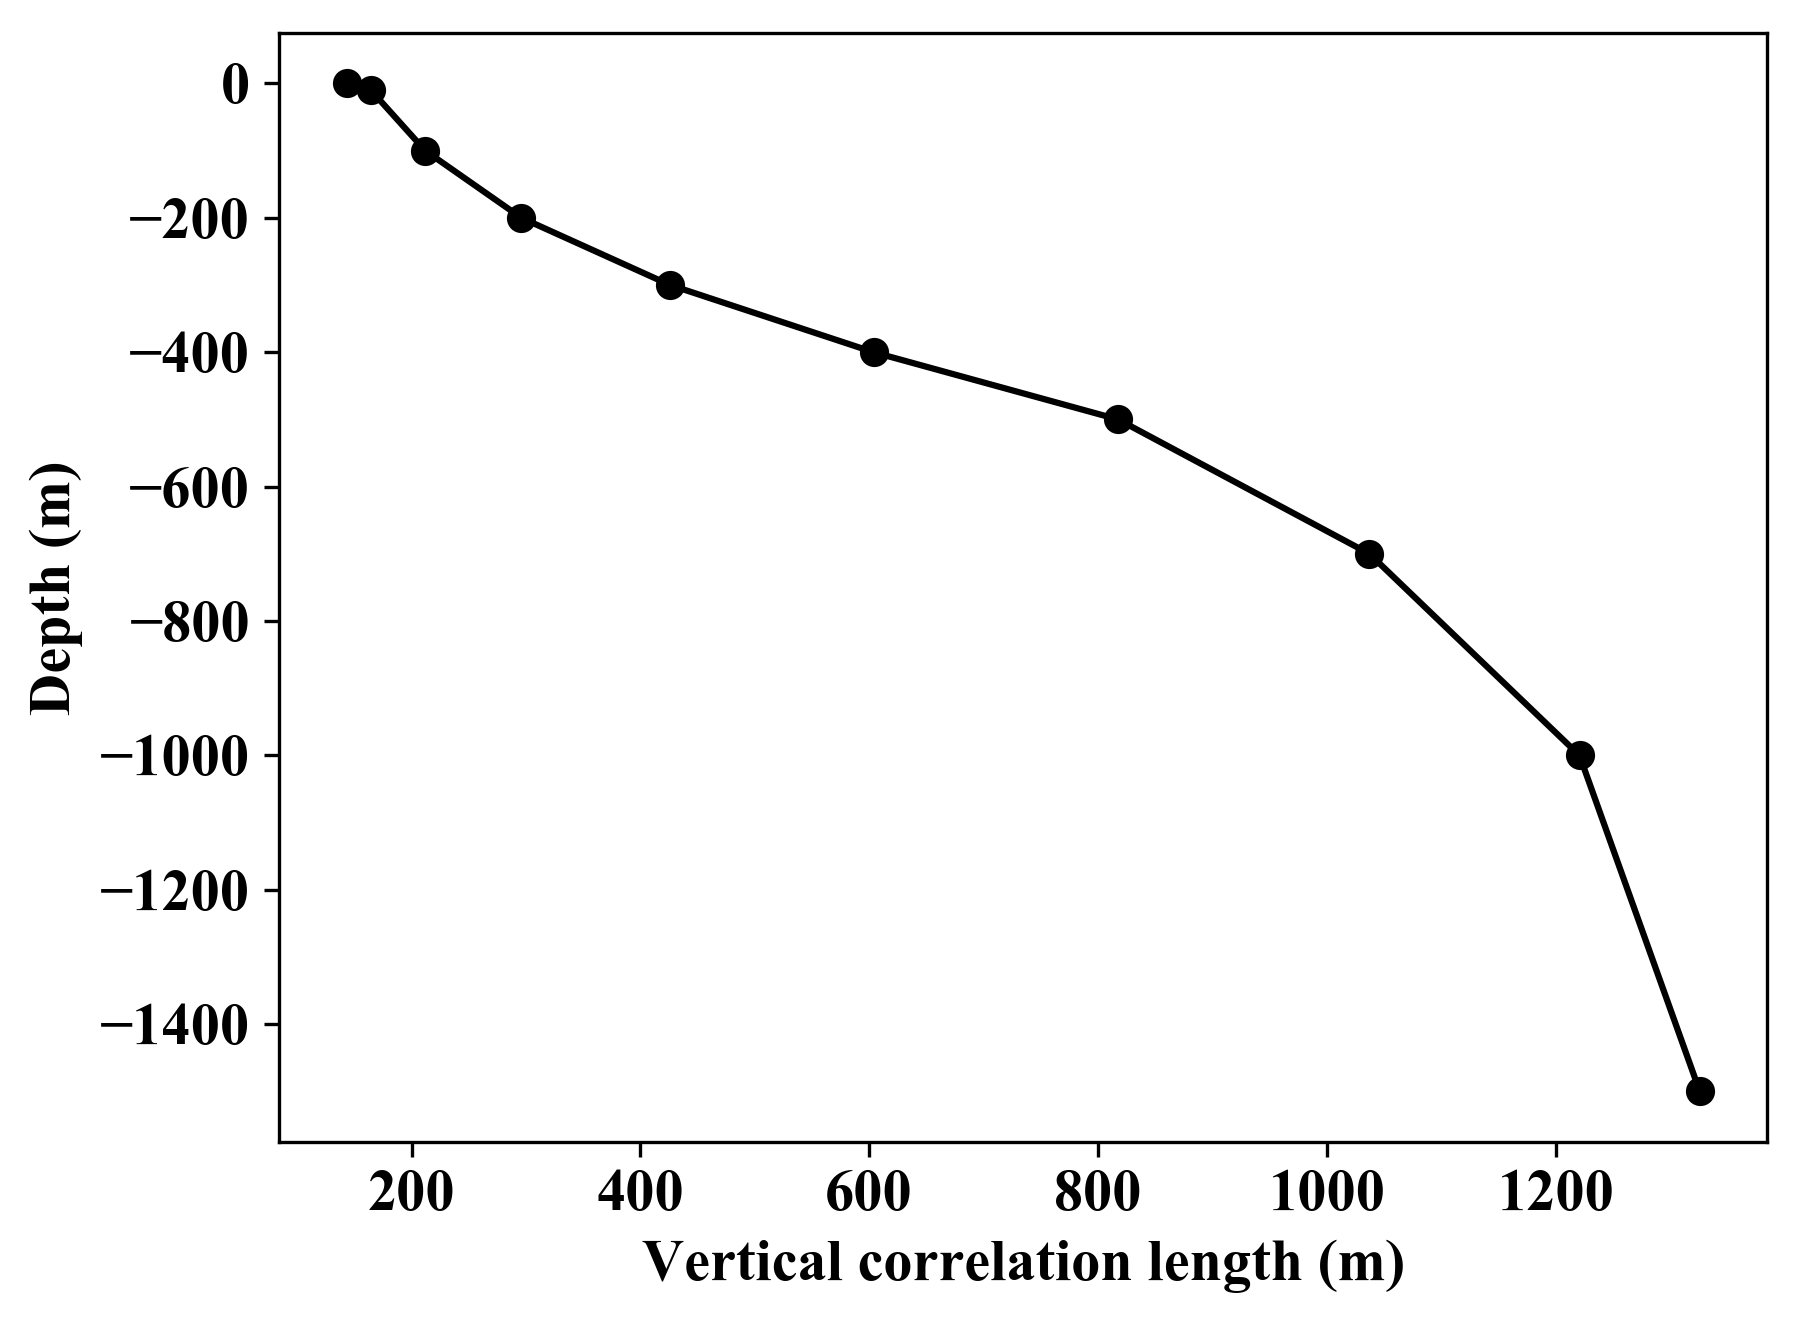

In [15]:
plot(lenz,-z, "ko-")
xlabel("Vertical correlation length (m)")
ylabel("Depth (m)");